In [7]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [8]:
os.chdir("/gdrive/MyDrive/Colab_Notebooks")
cwd = os.getcwd()
print(cwd)


/gdrive/MyDrive/Colab_Notebooks


In [13]:
files = "./Mask_Data"

data_dir = pathlib.Path(files)
data_dir

PosixPath('Mask_Data')

In [14]:
image_count = len(list(data_dir.glob('*/*.*')))
image_count

1517

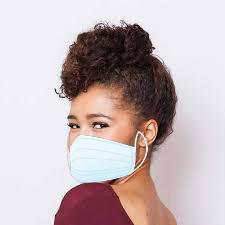

In [15]:
with_mask = list(data_dir.glob('with_mask/*'))
PIL.Image.open(str(with_mask[1]))

In [16]:
(with_mask[:5])

[PosixPath('Mask_Data/with_mask/augmented_image_134.jpg'),
 PosixPath('Mask_Data/with_mask/211-with-mask.jpg'),
 PosixPath('Mask_Data/with_mask/42-with-mask.jpg'),
 PosixPath('Mask_Data/with_mask/242-with-mask.jpg'),
 PosixPath('Mask_Data/with_mask/246-with-mask.jpg')]

In [17]:
IMG_SHAPE = (224, 224)

img = cv2.imread(str(with_mask[1]))
img.shape

(225, 225, 3)

In [18]:
cv2.resize(img, IMG_SHAPE).shape

(224, 224, 3)

In [19]:
mask_images_dict = {
    'with_mask' : list(data_dir.glob('with_mask/*')),
    'without_mask' : list(data_dir.glob('without_mask/*'))
}

In [20]:
mask_label_dict = {
    'with_mask' : 0,
    'without_mask' : 1
}

#### Redimensionner les images selon le modèle VGG16

In [21]:
X, y = [], []

for mask_label, images in mask_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMG_SHAPE)
        X.append(resized_img)
        y.append(mask_label_dict[mask_label])

#### Transformation des listes en np.array

In [22]:
X = np.array(X)
y = np.array(y)

#### Splitter les données en données d’apprentissage et test.

In [23]:
#Création du jeu de test et d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [24]:
#Création du jeu de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

In [25]:
y_train.shape

(1091,)

In [26]:
y_test.shape

(304,)

In [27]:
X.shape

(1517, 224, 224, 3)

In [28]:
#Normalisation des images
X_train_scaled = X_train/255
X_test_scaled = X_test/255
X_val_scaled = X_val/255

In [29]:
# Y to categorical
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [30]:
X_train_scaled.shape

(1091, 224, 224, 3)

In [31]:
X_test_scaled.shape

(304, 224, 224, 3)

In [32]:
X_val_scaled.shape

(122, 224, 224, 3)

Augmentation des données sur le X_train

In [33]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [34]:
datagen.fit(X_train_scaled)

#### Visualiser les images de la classe Avec_Masque et Sans_Masque

[0. 1.]


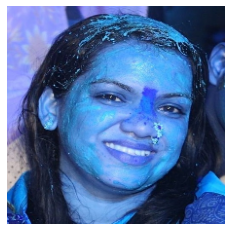

In [35]:
plt.axis('off')
plt.imshow(X_train_scaled[1])
print(y_train_categorical[1])

[1. 0.]


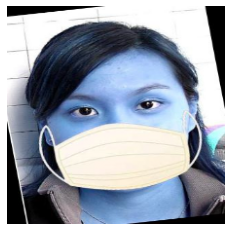

In [36]:
plt.axis('off')
plt.imshow(X_train_scaled[128])
print(y_train_categorical[128])

### Partie 2 : Architecture CNN sur Tensorflow

In [37]:
import keras
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

Visualisation du modèle VGG16

In [38]:
model = VGG16()
model.summary()

553476096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

#### Architecture VGG16

In [39]:
# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape = IMG_SHAPE+(3,)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### Ajout des 4 dernières couches - transformation de l'image en vecteur (flatten) et ajout des hidden layers (dense)

In [40]:
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________


Compilation et entraînement du modèle

In [41]:
model.compile(optimizer = 'adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [42]:
checkpoint_filepath = '/gdrive/MyDrive/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# Augmentation de X_train dans le .fit 
# Les poids sont sauvegardés à la fin de chaque epoch
history = model.fit(datagen.flow(X_train_scaled, y_train_categorical, batch_size = 32), epochs=10, validation_data = (X_val_scaled, y_val_categorical), callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


35/35 [==============================] - 45s 880ms/step - loss: 2.7560 - accuracy: 0.8918 - val_loss: 0.1293 - val_accuracy: 0.9426
Epoch 2/10
35/35 [==============================] - 19s 533ms/step - loss: 0.0195 - accuracy: 0.9927 - val_loss: 0.7547 - val_accuracy: 0.8197
Epoch 3/10
35/35 [==============================] - 25s 713ms/step - loss: 0.0644 - accuracy: 0.9835 - val_loss: 0.0839 - val_accuracy: 0.9672
Epoch 4/10
35/35 [==============================] - 24s 671ms/step - loss: 0.0154 - accuracy: 0.9927 - val_loss: 0.1757 - val_accuracy: 0.9098
Epoch 5/10
35/35 [==============================] - 20s 574ms/step - loss: 0.0150 - accuracy: 0.9945 - val_loss: 0.1932 - val_accuracy: 0.9098
Epoch 6/10
35/35 [==============================] - 19s 550ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0942 - val_accuracy: 0.9590
Epoch 7/10
35/35 [==============================] - 18s 509ms/step - loss: 0.0133 - accuracy: 0.9945 - val_loss: 0.1478 - val_accuracy: 0.9344
Epoch 8/10

Text(0, 0.5, 'loss')

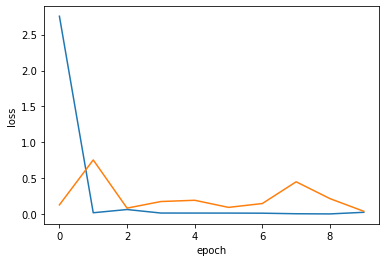

In [43]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')

10/10 - 5s - loss: 0.0974 - accuracy: 0.9638 - 5s/epoch - 475ms/step


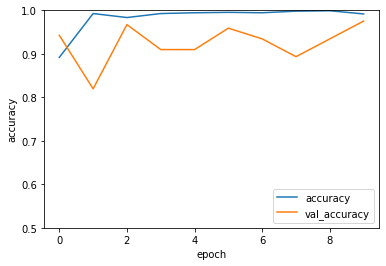

In [44]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test_scaled, y_test_categorical, verbose = 2)

Prédiction des y

In [45]:
y_prob = model.predict(X_test_scaled)
y_pred = y_prob.argmax(axis = -1)


In [46]:
y_pred[0]

1

In [47]:
y_test[0]

1

Matrice de confusion

In [48]:
confusion_matrice = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
confusion_matrice

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[153,   1],
       [ 10, 140]], dtype=int32)>

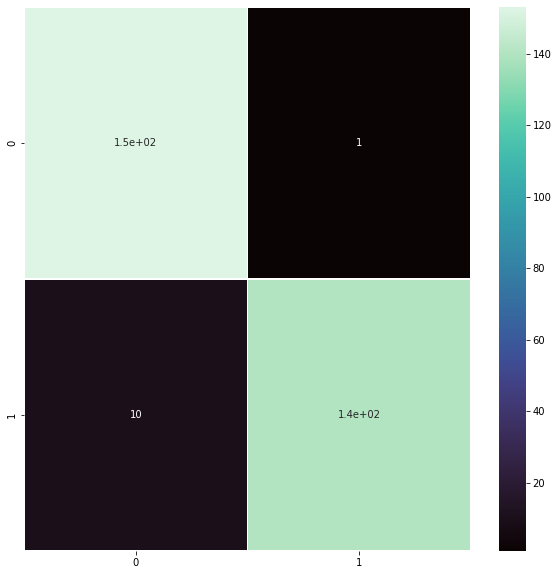

In [49]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrice, annot=True,cmap='mako', linecolor='white', linewidths=.3)

Sauvegarde du modèle


In [50]:
model.save(cwd + '/model_mask.h5', save_format = 'h5')

Partie 3 - Test

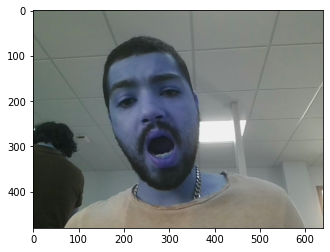

In [51]:
image_test = cv2.imread("./test/3.jpg")
plt.imshow(image_test)

without_mask


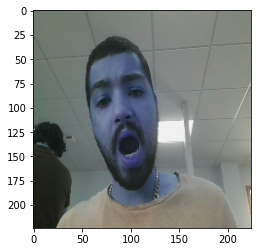

In [52]:
image_test = cv2.imread("./test/3.jpg")
image_test = cv2.resize(image_test, IMG_SHAPE)
image = np.expand_dims(np.array(image_test), axis = 0)/255
plt.imshow(image_test)
prob = model.predict(image)
prediction = prob.argmax(axis = -1)
for k, val in mask_label_dict.items(): 
      if prediction == val: 
          print(k)

#print(f'Prediction = {prediction}')
